# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)

from time import time
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (8, 4)})

# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](./data/CRISP-DM-BANK.pdf) for more information on the data and features.

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

From the paper, we have this quote:
>The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
df = pd.read_csv("./data/bank-additional-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [38]:
df["pdays"].value_counts(normalize=True) * 100.0

pdays
999    96.321744
3       1.065844
6       1.000291
4       0.286491
9       0.155385
2       0.148101
7       0.145673
12      0.140818
10      0.126250
5       0.111683
13      0.087404
11      0.067981
1       0.063125
15      0.058269
14      0.048558
8       0.043702
0       0.036418
16      0.026707
17      0.019423
18      0.016995
22      0.007284
19      0.007284
21      0.004856
25      0.002428
26      0.002428
27      0.002428
20      0.002428
Name: proportion, dtype: float64

Observations
- No columns are missing data
- The string (object) features can be coerced with 1-hot encoding
- The feature `duration` will be dropped per the description that it is not knowable a-priori therefore not valid to include in a predictive model
- The feature `pdays` will be dropped because 96% of them are invalid / never been contacted
- The numeric features can be processed with standard scaling

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

From the paper, we have this quote:
>... the goal was to increase efficiency of directed campaigns for long-term deposit subscriptions by reducing the number of contacts to do

They are looking for a way to increase the economic effectivity of a bank by making its marketing campaigns more efficient. Instead of mass campaigns, they want to use direct marketing, but in a way that maintains acceptance rate while requiring less contacts per customer.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [5]:
xformer = make_column_transformer(
    (
        OneHotEncoder(drop="if_binary"),
        make_column_selector(dtype_include=object),
    ),
    remainder=StandardScaler(),
    verbose_feature_names_out=False,
)

In [39]:
X = xformer.fit_transform(df.drop(columns=["pdays", "duration", "y"]))
y = df["y"] == "yes"

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The baseline classifier is a constant model that always returns the majority class
- The accuracy of this model is the rate of occurrence of this majority class

In [42]:
y_train.value_counts(normalize=True)

y
False    0.887346
True     0.112654
Name: proportion, dtype: float64

In [43]:
baseline_performance = np.max(y_train.value_counts(normalize=True))
baseline_performance

0.8873458288821987

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [44]:
lgr = LogisticRegression().fit(X_train, y_train)

### Problem 9: Score the Model

What is the accuracy of your model?

In [45]:
[
    lgr.score(X_train, y_train),
    lgr.score(X_test, y_test),
]

[0.8996471464180505, 0.9007477906186268]

The accuracy of the logistic regression model (using all defaults) is on par with the baseline model

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [46]:
classifier_params = {
    "KNeighborsClassifier": {
        "kwargs": {},
    },
    "DecisionTreeClassifier": {
        "kwargs": {"random_state": 42},
    },
    "LogisticRegression": {
        "kwargs": {},
    },
    "SVC": {
        "kwargs": {},
    },
}

In [50]:
def fit_and_time(classifier_name: str):
    tic = time()
    classifier = eval(classifier_name)(
        **classifier_params[classifier_name]["kwargs"]
    ).fit(X_train, y_train)
    return {
        "Model": classifier_name,
        "Train Time": time() - tic,
        "Train Accuracy": classifier.score(X_train, y_train),
        "Test Accuracy": classifier.score(X_test, y_test),
    }

In [48]:
results_list = [
    fit_and_time(classifier_name) for classifier_name in list(classifier_params.keys())
]

In [51]:
results_df = pd.DataFrame(results_list)
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,KNeighborsClassifier,0.003270,0.912434,0.895504
1,DecisionTreeClassifier,1.228693,0.995824,0.839759
2,LogisticRegression,0.127854,0.899647,0.900748
3,SVC,79.562778,0.904244,0.902302


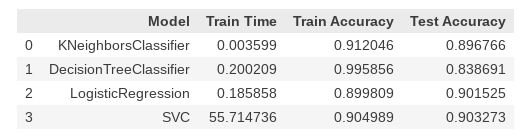

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric